# Customer Segmentation: Clustering

In this project, we will be performing an unsupervised clustering of data on the customer's records from a groceries firm's database. (Customer segmentation is the practice of separating customers into groups that reflect similarities among customers in each cluster). We will divide customers into segments to optimize the significance of each customer to the business. To modify products according to distinct needs and behaviours of the customers. It also helps the business to cater to the concerns of different types of customers.

#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
#Loading the dataset
data = pd.read_csv("marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


Data Cleaning

Feature Engineering

In order to, get a full grasp of what steps should I be taking to clean the dataset. Let us have a look at the information in data.

## Information on features 
data.info()

From the above output, we can conclude and note that:

There are missing values in income
Dt_Customer that indicates the date a customer joined the database is not parsed as DateTime

There are some categorical features in our data frame; as there are some features in dtype: object). So we will need to encode them into numeric forms later.

First of all, for the missing values, I am simply going to drop the rows that have missing income values.

In [3]:
#To remove the NA values
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


In the next step, I am going to create a feature out of "Dt_Customer" that indicates the number of days a customer is registered in the firm's database. However, in order to keep it simple, I am taking this value relative to the most recent customer in the record.

Thus to get the values I must check the newest and oldest recorded dates.

In [4]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-12-06
The oldest customer's enrolment date in the records: 2012-01-08


C:\Users\user\AppData\Local\Temp\ipykernel_15860\1415931200.py:1: UserWarning: Parsing '21-08-2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
C:\Users\user\AppData\Local\Temp\ipykernel_15860\1415931200.py:1: UserWarning: Parsing '19-01-2014' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
C:\Users\user\AppData\Local\Temp\ipykernel_15860\1415931200.py:1: UserWarning: Parsing '13-11-2012' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
C:\Users\user\AppData\Local\Temp\ipykernel_15860\1415931200.py:1: UserWarning: Parsing '13-03-2014' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  data["Dt_Customer"] = 

Creating a feature ("Customer_For") of the number of days the customers started to shop in the store relative to the last recorded date

In [5]:
#Created a feature "Customer_For"
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

Now we will be exploring the unique values in the categorical features to get a clear idea of the data.

In [6]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 

Total categories in the feature Education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


In the next bit, I will be performing the following steps to engineer some new features:

- Extract the "Age" of a customer by the "Year_Birth" indicating the birth year of the respective person.
- Create another feature "Spent" indicating the total amount spent by the customer in various categories over the span of two years.

- Create another feature "Living_With" out of "Marital_Status" to extract the living situation of couples.
- Create a feature "Children" to indicate total children in a household that is, kids and teenagers.
- To get further clarity of household, Creating feature indicating "Family_Size"
- Create a feature "Is_Parent" to indicate parenthood status
- Lastly, I will create three categories in the "Education" by simplifying its value counts.
- Dropping some of the redundant features

In [7]:
#Feature Engineering
#Age of customer today 
data["Age"] = 2021-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

Now that we have some new features let's have a look at the data's stats.

In [8]:
data

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,Graduate,58138.0,0,0,58,635,88,546,172,88,...,0,0,1,83894400000000000,64,1617,Alone,0,1,0
1,Graduate,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,10800000000000000,67,27,Alone,2,3,1
2,Graduate,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,40780800000000000,56,776,Partner,0,2,0
3,Graduate,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,5616000000000000,37,53,Partner,1,3,1
4,Postgraduate,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,27734400000000000,40,422,Partner,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,Graduate,61223.0,0,1,46,709,43,182,42,118,...,0,0,0,46742400000000000,54,1341,Partner,1,3,1
2236,Postgraduate,64014.0,2,1,56,406,0,30,0,0,...,0,0,0,5270400000000000,75,444,Partner,3,5,1
2237,Graduate,56981.0,0,0,91,908,48,217,32,12,...,0,0,0,27216000000000000,40,1241,Alone,0,1,0
2238,Postgraduate,69245.0,0,1,8,428,30,214,80,30,...,0,0,0,27302400000000000,65,843,Partner,1,3,1


In [9]:
#StandardScaler() is what scales the data

scaler = StandardScaler()
X = scaler.fit_transform(data.drop([ 'Education', 'Living_With'], axis=1))
X

array([[ 0.2340627 , -0.82303932, -0.92897224, ..., -1.26480327,
        -1.75867284, -1.5813886 ],
       [-0.23455948,  1.03993835,  0.90906569, ...,  1.40580564,
         0.45000895,  0.63235564],
       [ 0.76947764, -0.82303932, -0.92897224, ..., -1.26480327,
        -0.65433195, -1.5813886 ],
       ...,
       [ 0.18809052, -0.82303932, -0.92897224, ..., -1.26480327,
        -1.75867284, -1.5813886 ],
       [ 0.67538765, -0.82303932,  0.90906569, ...,  0.07050118,
         0.45000895,  0.63235564],
       [ 0.02470453,  1.03993835,  0.90906569, ...,  1.40580564,
         1.55434984,  0.63235564]])

In [10]:
# apply KMeans clustering - v the clustering library/means being used is KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [11]:
#Now we want to add a new column to our dataframe that has the clusters
# add the cluster labels to the dataframe
#kmeans.labels_ is used to add a label into the dataframe

data['cluster'] = kmeans.labels_

In [12]:
#printing the result
# print the first 10 rows of the resulting dataframe
data.head(10)

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,Complain,Response,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent,cluster
0,Graduate,58138.0,0,0,58,635,88,546,172,88,...,0,1,83894400000000000,64,1617,Alone,0,1,0,2
1,Graduate,46344.0,1,1,38,11,1,6,2,1,...,0,0,10800000000000000,67,27,Alone,2,3,1,1
2,Graduate,71613.0,0,0,26,426,49,127,111,21,...,0,0,40780800000000000,56,776,Partner,0,2,0,2
3,Graduate,26646.0,1,0,26,11,4,20,10,3,...,0,0,5616000000000000,37,53,Partner,1,3,1,1
4,Postgraduate,58293.0,1,0,94,173,43,118,46,27,...,0,0,27734400000000000,40,422,Partner,1,3,1,1
5,Postgraduate,62513.0,0,1,16,520,42,98,0,42,...,0,0,39139200000000000,54,716,Partner,1,3,1,0
6,Graduate,55635.0,0,1,34,235,65,164,50,49,...,0,0,65059200000000000,50,590,Alone,1,2,1,0
7,Postgraduate,33454.0,1,0,32,76,10,56,3,1,...,0,0,42163200000000000,36,169,Partner,1,3,1,1
8,Postgraduate,30351.0,1,0,19,14,0,24,3,3,...,0,1,47347200000000000,47,46,Partner,1,3,1,1
9,Postgraduate,5648.0,1,1,68,28,0,6,1,1,...,0,0,23155200000000000,71,49,Partner,2,4,1,1


In [13]:
data1 = data['cluster'].values
data1

array([2, 1, 2, ..., 2, 0, 1])

In [14]:
# Find the total number of customers in clusters 0, 1, and 2
num_cluster_0 = len(data[data['cluster'] == 0])
num_cluster_1 = len(data[data['cluster'] == 1])
num_cluster_2 = len(data[data['cluster'] == 2])
        
print(num_cluster_0)    
print(num_cluster_1)
print(num_cluster_2)


632
1067
517


<function matplotlib.pyplot.show(close=None, block=None)>

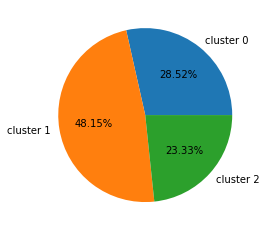

In [17]:
#PIE CHART
#Purpose of labels is to show what is what in the pie

import matplotlib.pyplot as plt

clustersnos = [632, 1067, 517]
clusters = ["cluster 0", "cluster 1", "cluster 2"]

plt.pie(clustersnos, labels = clusters, autopct = '%1.2f%%')
plt.show

In [ ]:
# Plot a scatter plot of Cluster against Individuals
plt.scatter(cluster_0['Income'], cluster_0['MntWines'])

# Add axis labels and a title to the plot
plt.xlabel('num_cluster_0', 'num_cluster_1', 'num_cluster_2')
plt.ylabel('cluster')
plt.title('Scatter plot of Cluster against Individuals)

# Display the plot
plt.show()